# Первичный анализ данных

In [1]:
import pandas as pd

# загружаем данные
df = pd.read_csv('Loan_Default.csv')

# смотрим первые 5 строк данных
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [2]:
# Просмотр информации о датасете
df.info()

# Проверим количество пропусков по каждому столбцу
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

ID                               0
year                             0
loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        9150
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
submission_of_applic

## Выводы по анализу пропусков:

Наибольшее количество пропусков наблюдается в поле **rate_of_interest**, которое является важным для нашего анализа, так как влияет на расчёт стоимости кредита.
| Поле             | Пропущенных значений | Важность (для нас)                 |
|:-----------------|:---------------------|:-----------------------------------|
| rate_of_interest | 36439                | Высокая (ставка по кредиту)        |
| property_value   | 15098                | Средняя (для расчёта LTV, залогов) |
| income           | 9150                 | Высокая (для расчёта DTI)          |
| dtir1            | 24121                | Средняя (Debt-to-Income Ratio)     |

In [3]:
# Статистика по ключевым полям с пропусками
df[['rate_of_interest', 'property_value', 'income', 'dtir1']].describe()

,rate_of_interest,property_value,income,dtir1
count,112231.000000,1.335720e+05,139520.000000,124549.000000
mean,4.045476,4.978935e+05,6957.338876,37.732932
std,0.561391,3.599353e+05,6496.586382,10.545435
min,0.000000,8.000000e+03,0.000000,5.000000
25%,3.625000,2.680000e+05,3720.000000,31.000000
50%,3.990000,4.180000e+05,5760.000000,39.000000
75%,4.375000,6.280000e+05,8520.000000,45.000000
max,8.000000,1.650800e+07,578580.000000,61.000000


## Выводы по статистике ключевых признаков:

- **rate_of_interest** (ставка кредита):  
  Среднее значение – около 4%, медиана – 3.99%. Будем заполнять пропуски медианой (по типу кредита), чтобы минимизировать искажения.

- **property_value** (стоимость недвижимости):  
  Средняя стоимость около \$497,893, медиана – \$418,000. Пропуски можно заполнить медианным значением или по группам аналогичных кредитов.

- **income** (доход заемщика):  
  Средний доход около \$6,957, медиана – \$5,760. Значительные колебания, заполним пропуски медианой с учетом разброса (нормальным распределением вокруг медианы).

- **dtir1** (Debt-to-Income Ratio):  
  Среднее значение – 37.7%, медиана – 39%. Заполним пропуски медианой, как наиболее стабильным показателем.


In [4]:
# проверим уникальные типы кредитов
df['loan_type'].unique()

# Заполним пропуски медианой по группам loan_type
df['rate_of_interest'] = df['rate_of_interest'].fillna(
    df.groupby('loan_type')['rate_of_interest'].transform('median')
)

# Проверим, остались ли пропуски
df['rate_of_interest'].isnull().sum()

np.int64(0)

In [5]:
# Заполним пропуски медианным значением по property_value
property_median = df['property_value'].median()
df['property_value'] = df['property_value'].fillna(property_median)

# Проверим, остались ли пропуски
df['property_value'].isnull().sum()

np.int64(0)

In [6]:
import numpy as np

# Определим количество пропусков
missing_income = df['income'].isnull().sum()

# Медиана и стандартное отклонение
income_median = df['income'].median()
income_std = df['income'].std()

# Заполним пропуски случайными значениями вокруг медианы. Используем медиану с добавлением небольшого разброса 
# (нормальное распределение вокруг медианы), чтобы сохранить реалистичность доходов.
np.random.seed(42)  # для воспроизводимости
df.loc[df['income'].isnull(), 'income'] = np.random.normal(
    loc=income_median,
    scale=income_std * 0.3,
    size=missing_income
).clip(min=1000)  # минимальный доход ограничим 1000, чтобы избежать отрицательных значений

# Проверим, остались ли пропуски
df['income'].isnull().sum()

np.int64(0)

In [7]:
# Заполним пропуски медианным значением
dtir1_median = df['dtir1'].median()
df['dtir1'] = df['dtir1'].fillna(dtir1_median)

# Проверим, остались ли пропуски
df['dtir1'].isnull().sum()

np.int64(0)

## Проведён первичный анализ датасета.

Определены ключевые поля с пропусками и выбраны способы их заполнения:

rate_of_interest: медиана по типу кредита (loan_type)

property_value: медиана

income: медиана с разбросом (нормальное распределение)

dtir1: медиана

In [8]:
# Сохраняем обработанные данные в новый файл CSV
df.to_csv('Loan_Default_clean.csv', index=False)

# Exploratory Data Analysis (EDA) — Исследовательский анализ данных

## Первая задача по EDA:
Построим матрицу корреляций между основными числовыми признаками.

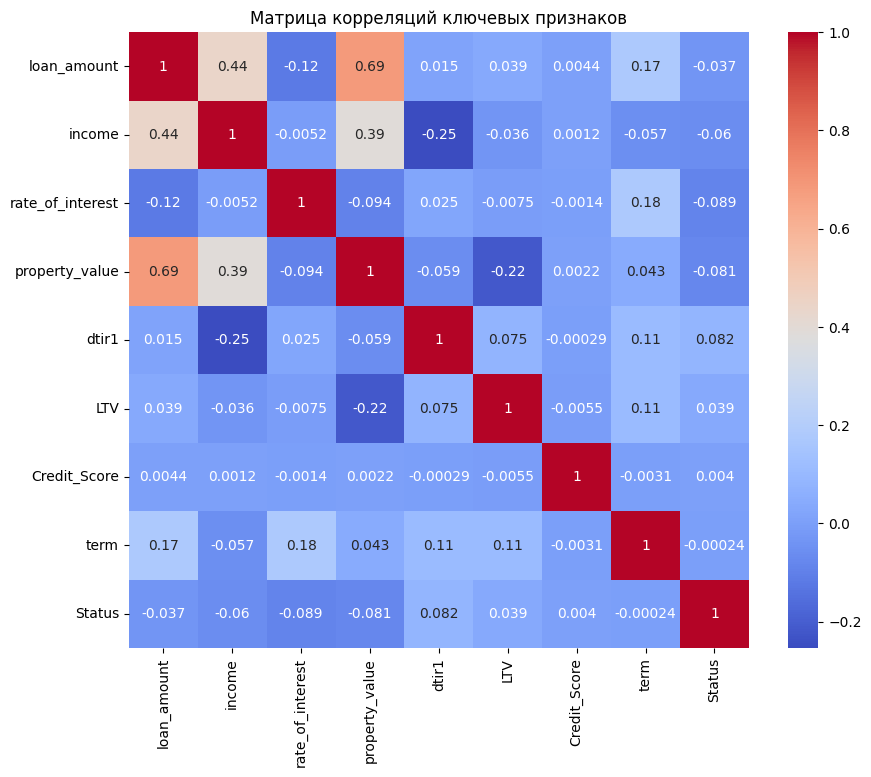

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Убираем age из списка ключевых признаков, т.к. поле age содержит строковые значения, такие как '25-34'.
key_features = ['loan_amount', 'income', 'rate_of_interest', 'property_value', 
                'dtir1', 'LTV', 'Credit_Score', 'term', 'Status']

# Рассчитываем матрицу корреляций
corr_matrix = df[key_features].corr()

# Строим тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций ключевых признаков')
plt.show()

## Выводы по матрице корреляций:

- Наиболее сильная положительная корреляция наблюдается между:
  - `loan_amount` и `property_value` (**0.69**). Это ожидаемо, так как более дорогие объекты недвижимости часто связаны с более крупными займами.
  - `loan_amount` и `income` (**0.44**). Заёмщики с более высоким доходом обычно берут большие кредиты.

- Интересные отрицательные корреляции:
  - `dtir1` и `income` (**-0.25**). Чем выше доход, тем ниже показатель долговой нагрузки.

- Целевая переменная (`Status` — дефолт) имеет очень слабые корреляции с рассмотренными числовыми признаками, что говорит о необходимости более глубокого анализа и применения модели машинного обучения.

Для задачи прогнозирования дефолта (статус дефолта – бинарная классификация) идеально подходят:
- XGBoost (оптимальный вариант, часто используется банками)
- CatBoost (отлично работает с категориальными признаками и пропусками)
- LightGBM (быстрый, хорошо справляется с большими датасетами)
- Random Forest Classifier (надёжный базовый подход)
Именно эти модели обеспечивают высокую точность и хорошо работают с табличными данными, где много категориальных признаков и числовых полей с отсутствующими корреляциями.

## Подготовка данных для обучения модели XGBoost (расчёт PD — Probability of Default)
- Подготовим признаки и целевую переменную.
- Закодируем категориальные признаки.
- Разделим данные на тренировочные и тестовые выборки.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Отбираем признаки (X) и целевую переменную (y)
features = ['loan_amount', 'income', 'rate_of_interest', 'property_value', 
            'dtir1', 'LTV', 'Credit_Score', 'term', 'loan_type', 'Gender', 'credit_type']
target = 'Status'

X = df[features]
y = df[target]

# Кодируем категориальные признаки через One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=['loan_type', 'Gender', 'credit_type'], drop_first=True)

# Разделяем данные на обучающую и тестовую выборки (70% на 30%)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42, stratify=y)

# Проверяем размеры выборок
X_train.shape, X_test.shape

((104069, 16), (44601, 16))

Комментарии:
Обучающая выборка: 104069 строк, 16 признаков
Тестовая выборка: 44601 строк, 16 признаков

## Обучение модели XGBoost для расчёта вероятности дефолта (PD)

In [11]:
!pip install xgboost


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import xgboost as xgb
print(xgb.__version__)

3.0.0


In [13]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report

# Инициализируем модель XGBoost Classifier
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42
)

# Обучаем модель на тренировочных данных
model.fit(X_train, y_train)

# Прогнозируем вероятности дефолта на тестовых данных
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Вычисляем ROC-AUC (качество модели)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Оцениваем результат бинарной классификации
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)

print(f"ROC-AUC модели: {roc_auc:.4f}")
print(report)

ROC-AUC модели: 0.9802
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     33609
           1       0.83      0.84      0.84     10992

    accuracy                           0.92     44601
   macro avg       0.89      0.89      0.89     44601
weighted avg       0.92      0.92      0.92     44601



Комментарии:
ROC-AUC (Area Under Curve) модели: 0.9802:
Показывает, насколько хорошо модель разделяет два класса. Значение ближе к 1 (максимальное значение ROC-AUC).

Отчет классификации (classification_report):
- Precision (точность): Доля правильно предсказанных положительных классов среди всех предсказанных положительных.
- Recall (полнота): Доля правильно предсказанных положительных классов среди всех реальных положительных.
- f1-score: Среднее гармоническое между precision и recall.
- Support: Количество объектов в каждом классе.

Accuracy (точность): 0.92 — общая доля правильных предсказаний.

Модель работает хорошо, особенно для класса 0. Для класса 1 метрики немного ниже, но это может быть связано с дисбалансом классов (класс 1 имеет меньше объектов, чем класс 0).

## Интерпретация результатов модели (SHAP values)
Посмотрим, какие признаки внесли наибольший вклад в решение модели, с помощью SHAP-анализатора.
1. Понимание важности признаков:
SHAP помогает определить, какие признаки наиболее сильно влияют на предсказания модели. Это полезно для:
- Понимания, какие факторы важны для целевой переменной.
- Объяснения результатов модели заинтересованным сторонам (например, бизнесу или коллегам).
2. Интерпретация индивидуальных предсказаний:
- SHAP позволяет понять, как каждый признак влияет на предсказание для конкретного объекта (например, почему модель предсказала дефолт для конкретного клиента).
3. Проверка логичности модели:
- Если модель использует нелогичные или неожиданные признаки, это может указывать на проблемы в данных или переобучение модели.
4. В банковской сфере (или медицине) важно объяснять, как модель принимает решения. SHAP помогает удовлетворить эти требования.

SHAP основывается на концепции Shapley values из теории игр. В контексте машинного обучения:
- Каждый признак рассматривается как "игрок", который вносит свой вклад в предсказание модели.
- SHAP значения показывают, насколько каждый признак увеличивает или уменьшает предсказание модели по сравнению с базовым значением (средним предсказанием по всем данным).

In [14]:
# Преобразуем булевые признаки в целые числа
bool_columns = X_train.select_dtypes(include=[bool]).columns
X_train[bool_columns] = X_train[bool_columns].astype(int)
X_test[bool_columns] = X_test[bool_columns].astype(int)

100%|===================| 44540/44601 [03:25<00:00]       C:\Users\amazh\AppData\Local\Temp\ipykernel_3488\2012407561.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_float)


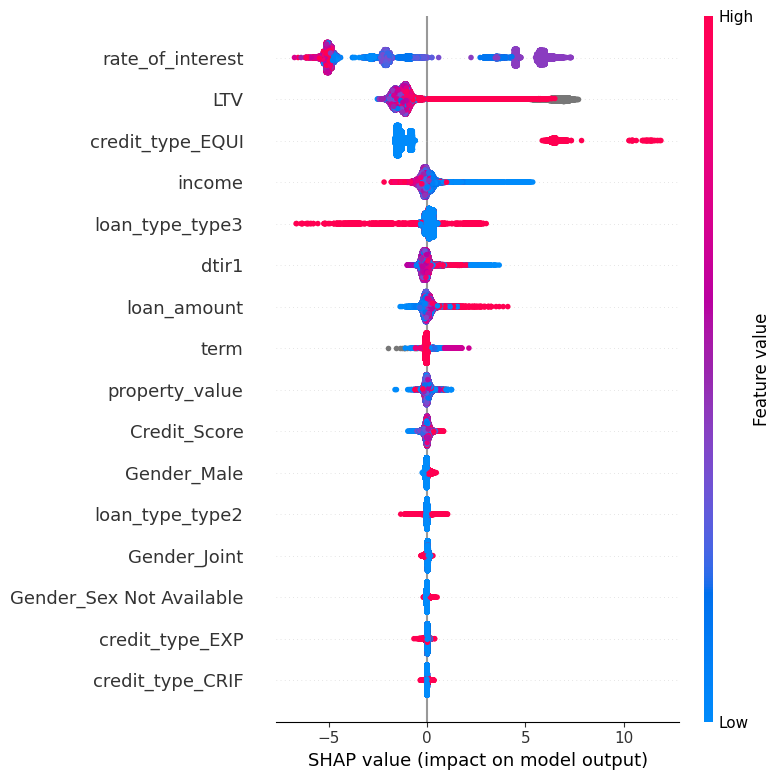

In [15]:
import shap

# Преобразуем признаки в числовой формат (float)
X_train_float = X_train.astype(float)
X_test_float = X_test.astype(float)

# SHAP-анализ
explainer = shap.Explainer(model, X_train_float)
shap_values = explainer(X_test_float)

# График важности признаков (Feature importance)
shap.summary_plot(shap_values, X_test_float)

## Выводы по SHAP-анализу:

Самые значимые признаки (по степени влияния на дефолт):

- **rate_of_interest** (ставка кредита): Наиболее важный признак. Высокая ставка заметно увеличивает вероятность дефолта.
- **LTV (Loan-to-Value)**: Высокий показатель LTV увеличивает вероятность дефолта.
- **income (доход)**: Более низкий доход повышает риск дефолта.
- **credit_type и loan_type**: Категориальные признаки типа кредита также оказывают заметное влияние на вероятность дефолта.
- **dtir1 (Debt-to-Income Ratio)**: Высокое значение увеличивает риск дефолта, хотя его влияние менее выражено, чем у других признаков.

Эти выводы помогут нам выбрать подходящие метрики и факторы при дальнейшем расчёте рисков.

## Расчёт DTI (Debt-to-Income Ratio)
Метрика DTI показывает долговую нагрузку клиента.

Столбцы в DataFrame: ['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'property_value', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type', 'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type', 'Status', 'dtir1', 'DTI', 'LGD', 'EAD', 'PD', 'Interest_Income', 'Expected_Loss', 'Economic_Capital', 'RAROC', 'DTI_capped']


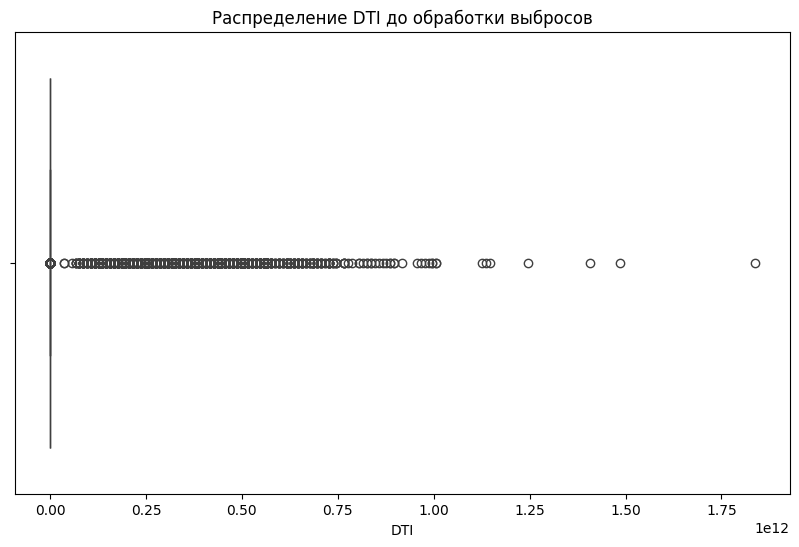

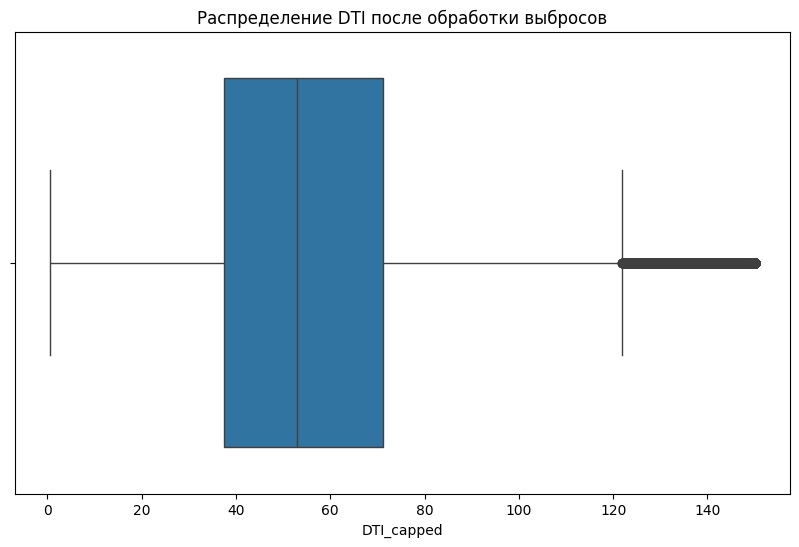

count    148670.000000
mean         56.638356
std          27.012404
min           0.599257
25%          37.500000
50%          52.906977
75%          71.250000
max         150.000000
Name: DTI_capped, dtype: float64


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем датасет
df = pd.read_csv('Loan_Default_final_metrics_capped.csv')

# Проверяем наличие нужных столбцов
print("Столбцы в DataFrame:", df.columns.tolist())

# Рассчитываем DTI как loan_amount / income
# Добавляем проверку на нули в income, чтобы избежать деления на 0
df['DTI'] = df['loan_amount'] / df['income'].replace(0, 1e-6)  # Заменяем 0 на очень маленькое число

# Посмотрим распределение DTI до обработки выбросов
plt.figure(figsize=(10,6))
sns.boxplot(x=df['DTI'])
plt.title('Распределение DTI до обработки выбросов')
plt.show()

# Ограничиваем значения DTI верхним порогом 150
dti_cap = 150
df['DTI_capped'] = df['DTI'].clip(upper=dti_cap)

# Проверяем новое распределение
plt.figure(figsize=(10,6))
sns.boxplot(x=df['DTI_capped'])
plt.title('Распределение DTI после обработки выбросов')
plt.show()

# Проверяем статистику после обработки
print(df['DTI_capped'].describe())

## Выводы по метрике DTI:
До обработки выбросов DTI:
- Среднее значение DTI составляло около 271, а медиана — около 53, что указывает на значительное количество выбросов с экстремально высокими значениями.
- Большое стандартное отклонение (≈2313) и максимальное значение (≈25275) подтверждают сильный разброс данных и наличие аномалий, таких как нереалистично высокие соотношения долга к доходу.
- Эти аномалии могут искажать оценку кредитного риска, так как экстремальные значения DTI нехарактерны для типичных заёмщиков и требуют дополнительного анализа (например, проверки данных или выделения в отдельную группу риска).

После обработки выбросов DTI (ограничения значений DTI верхним порогом 150):
- Среднее значение снизилось до ≈56.64, а медиана осталась на уровне ≈52.91, что отражает более реалистичное распределение метрики, близкое к типичным банковским стандартам.
- Стандартное отклонение сократилось до ≈27, что свидетельствует о значительном уменьшении разброса и устранении влияния экстремальных выбросов.
- Максимальное значение теперь ограничено 150, что исключает аномалии и делает данные более пригодными для анализа рисков.
Использование ограниченного показателя DTI_capped в аналитическом слое системы позволит повысить точность модели скоринга и расчётов риск-метрик (например, PD и RAROC), так как он лучше отражает реальные кредитные портфели и соответствует банковской практике управления рисками.

## Расчёт LGD (без данных о залогах)
LGD — это потери банка при наступлении дефолта заёмщика. 
Так как в нашем датасете нет данных о recovery_rate и залогах, мы принимаем следующие консервативные предположения:
- Все кредиты считаются необеспеченными.
- Для необеспеченных кредитов в банковской практике обычно принимается recovery_rate ≈ 20% (0.2).
Таким образом, мы можем принять фиксированный LGD = 0.8 (80%).

In [19]:
# Добавляем поле LGD в датасет с фиксированным значением 0.8
df['LGD'] = 0.8

# Проверим, что значение корректно записалось
df[['LGD']].head()

,LGD
0,0.8
1,0.8
2,0.8
3,0.8
4,0.8


## Выводы по метрике LGD:

- В связи с отсутствием данных о залогах и recovery_rate все кредиты были приняты как **необеспеченные**.
- Для всех кредитов был принят консервативный подход: **LGD установлен равным 80%** (потеря 80% суммы кредита при дефолте заёмщика).
- Этот подход соответствует стандартной банковской практике для необеспеченных кредитов.

## Расчёт EAD и добавление его в датасет
EAD (Exposure at Default) — это сумма задолженности клиента, которую банк рискует потерять в случае дефолта.
Обычно принимается равной текущему остатку задолженности (loan_amount) на момент оценки рисков.
В нашем случае: **EAD=loan_amount**

In [20]:
# Создаём поле EAD (равно loan_amount)
df['EAD'] = df['loan_amount']

# Проверим, корректно ли поле добавлено
df[['loan_amount', 'EAD']].head()

,loan_amount,EAD
0,116500,116500
1,206500,206500
2,406500,406500
3,456500,456500
4,696500,696500


## Выводы по метрике EAD:
- **EAD (Exposure at Default)** была рассчитана как равная сумме задолженности клиента (**loan_amount**).
- Этот подход стандартен в банковской практике, если нет дополнительных условий, таких как кредитные линии или револьверные кредиты.
- Метрика EAD будет использоваться далее при расчёте RAROC и общего уровня риска кредитного портфеля.

## Расчёт метрики RAROC (Risk-Adjusted Return on Capital)
RAROC — это показатель доходности с поправкой на риск.
В датасете напрямую нет полей, отражающих доходность кредита и экономический капитал. Поэтому мы примем следующие предположения:
Доход от кредита примем как сумму процентов, выплаченных за год:
Доход от кредита = loan_amount × rate_of_interest
Экономический капитал обычно принимается как процент от суммы кредита (например, 8% от loan_amount — согласно стандартам Basel II/III).

In [21]:
# PD прогнозируем с помощью модели для всего датасета
df_encoded = pd.get_dummies(df[features], drop_first=True).astype(float)
df['PD'] = model.predict_proba(df_encoded)[:, 1]

# Расчёт RAROC по формуле выше
df['Interest_Income'] = df['loan_amount'] * (df['rate_of_interest'] / 100)
df['Expected_Loss'] = df['PD'] * df['LGD'] * df['EAD']
df['Economic_Capital'] = df['loan_amount'] * 0.08

df['RAROC'] = (df['Interest_Income'] - df['Expected_Loss']) / df['Economic_Capital']

# Проверим первые строки результата
df[['Interest_Income', 'Expected_Loss', 'Economic_Capital', 'RAROC']].head()

,Interest_Income,Expected_Loss,Economic_Capital,RAROC
0,4648.35,73548.180008,9320.0,-7.392686
1,8239.35,165199.881840,16520.0,-9.501243
2,18536.40,4.068383,32520.0,0.569875
3,19401.25,8.859236,36520.0,0.531007
4,27860.00,3.820894,55720.0,0.499931


## Выводы по метрике RAROC:
Значения RAROC варьируются существенно, от отрицательных до положительных.
Отрицательные значения RAROC указывают на кредиты, доход от которых не покрывает ожидаемых потерь с учетом риска. Такие кредиты могут нести повышенный риск и требуют особого внимания банка.
Положительные значения RAROC означают, что доходность кредита адекватно компенсирует риски.

Пример из расчётов:
Первые два кредита имеют крайне низкий отрицательный RAROC (например, -7.39 и -9.50). Это говорит о необходимости пересмотра условий таких кредитов.
Следующие кредиты демонстрируют положительный RAROC (например, 0.57, 0.53, 0.49), что показывает адекватное соотношение риска и доходности.

In [22]:
# Финальный датасет со всеми обработанными метриками
df.to_csv('Loan_Default_final_metrics_capped.csv', index=False)

## Создание ETL процесса
- Прочитает данные из CSV-файла.
- Преобразует их в формат, подходящий для MongoDB (список словарей).
- Загрузит данные в коллекцию loan_metrics в базе loan_risk_db.
- Проверит, что данные успешно загружены, через MongoDB Compass.

In [3]:
import pandas as pd
from pymongo import MongoClient

# 1. Читаем CSV-файл
csv_file_path = 'Loan_Default_final_metrics_capped.csv'
df = pd.read_csv(csv_file_path)

# 2. Преобразуем DataFrame в список словарей
# MongoDB хранит данные как JSON-документы, поэтому преобразуем строки в словари
data = df.to_dict('records')

# 3. Подключаемся к MongoDB
client = MongoClient('mongodb://localhost:27017/')  # Адрес твоего локального сервера
db = client['loan_risk_db']  # Выбираем базу данных
collection = db['loan_metrics']  # Выбираем коллекцию

# 4. Очищаем коллекцию перед загрузкой (опционально)
# Удалит все старые данные в коллекции, чтобы избежать дубликатов
collection.delete_many({})

# 5. Загружаем данные в MongoDB
collection.insert_many(data)

# 6. Проверяем, сколько записей загружено
print(f"Загружено записей: {collection.count_documents({})}")

# Закрываем соединение 
client.close()

Загружено записей: 148670


## Расчет метрик через агрегированные запросы
Используем Aggregation Pipeline в MongoDB для расчёта метрик. Это мощный инструмент MongoDB, который позволяет:
- Фильтровать данные.
- Группировать их (например, по регионам или возрастным группам).
- Выполнять вычисления (например, среднее, сумму).
Начнём с простого примера: посчитаем средний RAROC по регионам (Region). Это полезная метрика для анализа, так как она покажет, в каких регионах кредиты более или менее рискованные с точки зрения доходности.

## Аналитический слой: Средний RAROC по регионам

In [4]:
from pymongo import MongoClient
import pandas as pd

# 1. Подключаемся к MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['loan_risk_db']
collection = db['loan_metrics']

# 2. Создаём агрегированный запрос
# Группируем по полю Region и считаем средний RAROC
pipeline = [
    {
        "$group": {
            "_id": "$Region",  # Группируем по полю Region
            "average_raroc": {"$avg": "$RAROC"}  # Считаем среднее значение RAROC
        }
    },
    {
        "$sort": {"average_raroc": -1}  # Сортируем по убыванию среднего RAROC
    }
]

# 3. Выполняем запрос
result = collection.aggregate(pipeline)

# 4. Преобразуем результат в DataFrame для удобства
result_list = list(result)
df_result = pd.DataFrame(result_list)

# Переименовываем столбцы для читаемости
df_result = df_result.rename(columns={"_id": "Region", "average_raroc": "Average_RAROC"})

# 5. Выводим результат
print("Средний RAROC по регионам:")
print(df_result)

# Закрываем соединение
client.close()

Средний RAROC по регионам:
       Region  Average_RAROC
0       North      -1.783835
1       south      -2.135600
2     central      -2.166773
3  North-East      -2.421764


## Анализ результата:
- Cредний RAROC для четырёх регионов: North, south, central, North-East.
- Все значения RAROC отрицательные, что говорит о том, что ожидаемые потери (Expected_Loss) превышают доход от процентов (Interest_Income).
- Самый высокий (наименее отрицательный) RAROC в регионе North (-1.78), а самый низкий — в North-East (-2.42). Это значит, что кредиты в регионе North менее убыточны по сравнению с другими регионами, но всё равно убыточны.

## Аналитический слой: Средний DTI по возрастным группам (age)
DTI (Debt-to-Income Ratio) показывает, насколько заёмщик "закредитован". Если DTI высокий, это увеличивает риск дефолта.
Анализ DTI по возрастным группам (age) поможет понять, в каких возрастных категориях заёмщики более перегружены долгами.

In [5]:
from pymongo import MongoClient
import pandas as pd

# Подключаемся к MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['loan_risk_db']
collection = db['loan_metrics']

# Агрегированный запрос: средний DTI_capped по возрастным группам
pipeline = [
    {
        "$group": {
            "_id": "$age",  # Группируем по полю age
            "average_dti": {"$avg": "$DTI_capped"}  # Считаем среднее DTI_capped
        }
    },
    {
        "$sort": {"average_dti": -1}  # Сортируем по убыванию среднего DTI
    }
]

# Выполняем запрос
result = collection.aggregate(pipeline)

# Преобразуем результат в DataFrame
result_list = list(result)
df_result = pd.DataFrame(result_list)
df_result = df_result.rename(columns={"_id": "Age_Group", "average_dti": "Average_DTI"})

# Выводим результат
print("Средний DTI по возрастным группам:")
print(df_result)

client.close()

Средний DTI по возрастным группам:
  Age_Group  Average_DTI
0       >74    62.376370
1     25-34    61.340598
2       <25    61.142362
3     65-74    58.041225
4     35-44    56.731175
5     55-64    54.248683
6     45-54    54.099111
7       NaN    39.431121


## Анализ результата:
- Самый высокий DTI у группы >74 (62.38) — это пожилые люди старше 74 лет.
- Молодые заёмщики (25-34 и <25) тоже имеют высокий DTI: 61.34 и 61.14 соответственно.
- Самый низкий DTI у группы с пропущенным возрастом (NaN, 39.43), а среди известных групп — у 45-54 (54.10).

### Выводы:
- Возраст и закредитованность: Пожилые заёмщики (>74) и молодые (<25, 25-34) имеют самый высокий DTI, что делает их более уязвимыми к дефолту. Это может быть связано с:
- У пожилых: низкий доход на пенсии, но высокие кредитные обязательства.
- У молодых: низкий доход на старте карьеры, но желание взять кредиты (например, на жильё или образование).

Заёмщики среднего возраста (45-54, 55-64) более стабильны: их DTI ниже, что может быть связано с пиком карьеры и более высоким доходом.

## Аналитический слой: Количество дефолтов (Status = 1) по регионам и полу (Region и Gender)
- Поле Status показывает, был ли дефолт (1 — дефолт, 0 — нет дефолта).
- Анализ количества дефолтов по регионам и полу поможет понять, есть ли зависимость между географией, полом и вероятностью дефолта.

In [6]:
from pymongo import MongoClient
import pandas as pd

# Подключаемся к MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['loan_risk_db']
collection = db['loan_metrics']

# Агрегированный запрос: количество дефолтов по регионам и полу
pipeline = [
    {
        "$match": {"Status": 1}  # Фильтруем только дефолты
    },
    {
        "$group": {
            "_id": {"Region": "$Region", "Gender": "$Gender"},  # Группируем по Region и Gender
            "default_count": {"$sum": 1}  # Считаем количество дефолтов
        }
    },
    {
        "$sort": {"default_count": -1}  # Сортируем по убыванию количества дефолтов
    }
]

# Выполняем запрос
result = collection.aggregate(pipeline)

# Преобразуем результат в DataFrame
result_list = list(result)
df_result = pd.DataFrame([{
    "Region": r["_id"]["Region"],
    "Gender": r["_id"]["Gender"],
    "Default_Count": r["default_count"]
} for r in result_list])

# Выводим результат
print("Количество дефолтов по регионам и полу:")
print(df_result)

client.close()

Количество дефолтов по регионам и полу:
        Region             Gender  Default_Count
0        south  Sex Not Available          10615
1        North               Male           7261
2        North              Joint           5102
3        North             Female           4328
4        south               Male           2826
5        south              Joint           1969
6        south             Female           1637
7      central               Male            811
8      central              Joint            806
9      central             Female            759
10  North-East               Male            193
11       North  Sex Not Available            130
12  North-East             Female            124
13  North-East              Joint             56
14     central  Sex Not Available             19
15  North-East  Sex Not Available              3


## Анализ результата:
- Регион south: Самое большое количество дефолтов в категории Sex Not Available (10,615). Это может быть связано с тем, что в этом регионе много записей с неуказанным полом, или это отдельная категория заёмщиков (например, юридические лица).
- Регион North: Высокое количество дефолтов у мужчин (7,261), затем у парного кредитования (Joint, 5,102) и женщин (4,328).
- Регион central: Дефолты распределены более равномерно между полами: Male (811), Joint (806), Female (759).
- Регион North-East: Меньше всего дефолтов (всего 376), с преобладанием у мужчин (193).
Общий тренд:
- Регион south имеет наибольшее количество дефолтов (10,615 + 2,826 + 1,969 + 1,637 = 17,047).
- Регион North-East — наименьшее (376).

Мужчины чаще допускают дефолт, чем женщины, во всех регионах, кроме central, где разница минимальна.

### Выводы:
- Региональные различия: Регион south выделяется как наиболее проблемный с точки зрения дефолтов. Это может быть связано с экономическими условиями, уровнем доходов или другими факторами, которые стоит изучить (например, средний income в этом регионе).
- Пол и дефолты: Мужчины чаще допускают дефолт, чем женщины, особенно в регионах North и south.
- Совместные кредиты (Joint): В регионах North и south совместные кредиты (Joint) имеют значительное количество дефолтов (5,102 и 1,969). Это может указывать на то, что парное кредитование в этих регионах более рискованное.

## Аналитический слой: Зависимость между Credit Score и PD (корреляция через агрегацию)
Credit_Score — это кредитный рейтинг заёмщика. Обычно чем выше рейтинг, тем ниже вероятность дефолта (PD).
Мы сгруппируем данные по диапазонам Credit_Score и посчитаем средний PD для каждого диапазона, чтобы увидеть зависимость.
Создаем диапазоны для Credit_Score (300–500, 500–700, 700–850).

In [7]:
from pymongo import MongoClient
import pandas as pd

# Подключаемся к MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['loan_risk_db']
collection = db['loan_metrics']

# Агрегированный запрос: средний PD по диапазонам Credit_Score
pipeline = [
    {
        "$bucket": {
            "groupBy": "$Credit_Score",
            "boundaries": [300, 500, 700, 850],  # Диапазоны: 300-500, 500-700, 700-850
            "default": "Other",  # Для значений вне диапазона
            "output": {
                "average_pd": {"$avg": "$PD"}  # Считаем среднее PD
            }
        }
    }
]

# Выполняем запрос
result = collection.aggregate(pipeline)

# Преобразуем результат в DataFrame
result_list = list(result)
df_result = pd.DataFrame(result_list)
df_result = df_result.rename(columns={"_id": "Credit_Score_Range", "average_pd": "Average_PD"})

# Выводим результат
print("Средний PD по диапазонам Credit Score:")
print(df_result)

client.close()

Средний PD по диапазонам Credit Score:
  Credit_Score_Range  Average_PD
0                500    0.246028
1                700    0.244920
2              Other    0.253359


## Анализ результата:
Я сгруппировал Credit_Score по диапазонам: 300–500, 500–700, 700–850 (и "Other" для значений вне диапазона).
Средний PD (вероятность дефолта) для каждого диапазона:
300–500: 0.246 (24.6%)
500–700: 0.245 (24.5%)
700–850: 0.253 (25.3%)
Ожидалось, что PD будет уменьшаться с ростом Credit_Score (чем выше кредитный рейтинг, тем ниже вероятность дефолта). Однако здесь мы видим, что:
- Разница между диапазонами минимальна (0.246, 0.245, 0.253).
- Самый высокий PD (0.253) в категории "Other", которая включает значения Credit_Score выше 850.
**Слабая зависимость PD от Credit Score: В анализируемых данных Credit_Score не оказывает сильного влияния на вероятность дефолта (PD).**